In [130]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.semi_supervised import LabelPropagation
from sklearn.metrics import make_scorer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
import cv2
import sys
sys.path.append('../../utils')
import config_handling as conf
from database import Database
from file_io import path_handler
import matplotlib.image as mpimg
import time


In [2]:

# Ensure TensorFlow/PyTorch compatibility if needed for deep feature extraction
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

2025-01-09 12:24:17.231850: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736425457.253142  145803 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736425457.261516  145803 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-09 12:24:17.282734: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
config = conf.read_config('../../config/automotive.conf.ini')
config.read('config.ini')
connection_type = config['settings']['connection']
connection_type
user = config[connection_type]['user']
pw = config[connection_type]['pw']
host = config[connection_type]['host']
db = config[connection_type]['db']
port = config[connection_type].getint('port')
db = Database(host,
              port,
              user,
              pw,
              db
              )
db.connect()
#image directory: 
basedir = config['settings']['image_directory']

Connection established


In [4]:
# Define angle tags and their corresponding ordinal positions
ANGLES = ["front", "frontleft", "left", "rearleft", "rear", "rearright", "right", "frontright"]
ORDINAL_MAP = {tag: i for i, tag in enumerate(ANGLES)}

In [5]:
# Penalty matrix based on circular adjacency
PENALTY_MATRIX = np.zeros((len(ANGLES), len(ANGLES)))
for i in range(len(ANGLES)):
    for j in range(len(ANGLES)):
        distance = min(abs(i - j), len(ANGLES) - abs(i - j))
        PENALTY_MATRIX[i, j] = distance

In [133]:
# Function to extract image features using ResNet50
def extract_features(df, use_bounding_boxes=False, time_testing=False):
    base_model = ResNet50(weights="imagenet", include_top=False, pooling="avg")
    model = Model(inputs=base_model.input, outputs=base_model.output)

    features = []
    time_details = []
    for row in df.iterrows():
    #for i, path in enumerate(df['abs_image_path']):
        if time_testing:
            start = time.time()
        image_path = row[1]['abs_image_path']
        img = cv2.imread(image_path)
        x1 = row[1]['yolobox_top_left_x']
        y1 = row[1]['yolobox_top_left_y']
        x2 = row[1]['yolobox_bottom_right_x']
        y2 = row[1]['yolobox_bottom_right_y']
        if use_bounding_boxes and x1 != x2:
            img = img[y1:y2, x1:x2]

        img = cv2.resize(img, (224, 224))
        img = preprocess_input(img)
        img = np.expand_dims(img, axis=0)

        feature = model.predict(img)
        features.append(feature.squeeze())
        if time_testing:
            time_details.append(time.time()-start)
    if not time_testing:
        return np.array(features)
    else: 
        return time_details

In [7]:

def bbox_to_ints(df):
    df = df.copy()
    for col in ['yolobox_top_left_x', 'yolobox_top_left_y', 'yolobox_bottom_right_x', 'yolobox_bottom_right_y']:
        df[col] = df[col].astype(int)
    return df

In [8]:
#get the labeled data: 
tags = db.execute_query("""SELECT image_id, 
                            angle, 
                            images.yolobox_top_left_x, 
                            images.yolobox_top_left_y, 
                            images.yolobox_bottom_right_x, 
                            images.yolobox_bottom_right_y, 
                            images.image_path 
                        FROM angletags 
                        JOIN images on images.id = angletags.image_id 
                        WHERE 
                            manual_annotation = 1""")
labeled_data = pd.DataFrame(tags).fillna(-1)
labeled_data = bbox_to_ints(labeled_data)

labeled_data.sample(5)

image_id       angle  yolobox_top_left_x  yolobox_top_left_y  \
3664   1109309       front                 133                  63   
3406   1248275      crappy                  -1                  -1   
3869   1450185   rearright                  36                   3   
1441   1559046  frontright                  81                 119   
2775   1006149      crappy                  54                 140   

      yolobox_bottom_right_x  yolobox_bottom_right_y  \
3664                     601                     477   
3406                      -1                      -1   
3869                     741                     541   
1441                     699                     428   
2775                     719                     466   

                                             image_path  
3664  opel\Mokka\9e8b0266-9fb8-4cf5-980c-be5ae58cf21...  
3406  land-rover\Range Rover Velar\f43f44a9-d804-4a4...  
3869  bmw\3 Reeks (alle)\89e12bfe-8a98-4c30-9fe1-e9e...  
1441  bmw\Z Reeks (alle)\dadfe703-2b17-4d3b-b4ed-9c4...  
2775  peugeot\5008\3ba9fd74-6906-4c7a-b351-9d654dd27...

In [9]:
#get the unlabeled data: 
untagged = db.execute_query("""SELECT 
                                image_path, 
                                yolobox_top_left_x,
                                yolobox_top_left_y,
                                yolobox_bottom_right_x,
                                yolobox_bottom_right_y
                            FROM images
                            LEFT JOIN angletags on images.id = angletags.image_id
                            WHERE angletags.pk IS NULL
""")
unlabeled_data = pd.DataFrame(untagged).fillna(-1)
unlabeled_data = bbox_to_ints(unlabeled_data)

unlabeled_data.sample(5)

image_path  \
5420560   /mercedes-benz/E-Klasse (alle)/68d068dd-3a9b-4...   
8064086   /citroen/C4 (alle)/0ffd075a-97e0-4f82-8b17-dd9...   
11745202  /volkswagen/T6 (alle)/2ec627d5-bbe7-4070-a86e-...   
10514376  /skoda/Kamiq/8c73885b-293b-4d2c-975b-ca9b414da...   
702177    peugeot\Partner\37b41f66-1f89-4c65-8a5a-975e85...   

          yolobox_top_left_x  yolobox_top_left_y  yolobox_bottom_right_x  \
5420560                  145                 223                     703   
8064086                   -1                  -1                      -1   
11745202                  -1                  -1                      -1   
10514376                  -1                  -1                      -1   
702177                   267                 186                     566   

          yolobox_bottom_right_y  
5420560                      454  
8064086                       -1  
11745202                      -1  
10514376                      -1  
702177                       477

In [10]:
unlabeled_data["image_path"] = unlabeled_data["image_path"].apply(lambda x: x.replace('\\', '/'))
unlabeled_data["abs_image_path"]= basedir + '/' + unlabeled_data["image_path"]
labeled_data["image_path"] = labeled_data["image_path"].apply(lambda x: x.replace('\\', '/'))
labeled_data["abs_image_path"]= basedir + '/' + labeled_data["image_path"]

In [18]:
#image_paths_labeled = labeled_data["abs_image_path"].values
labels = labeled_data["angle"].values

#image_paths_unlabeled = unlabeled_data["abs_image_path"].values


In [12]:

# Optionally include bounding boxes
use_bounding_boxes = True  # Set to False if bounding boxes are not needed
#bounding_boxes_labeled = labeled_data[["yolobox_top_left_x", "yolobox_top_left_y", "yolobox_bottom_right_x", "yolobox_bottom_right_y"]].values if use_bounding_boxes else None
#bounding_boxes_unlabeled = unlabeled_data[["yolobox_top_left_x", "yolobox_top_left_y", "yolobox_bottom_right_x", "yolobox_bottom_right_y"]].values if use_bounding_boxes else None


In [13]:
#bounding_boxes_labeled_df = pd.DataFrame(bounding_boxes_labeled)
#bounding_boxes_unlabeled_df = pd.DataFrame(bounding_boxes_unlabeled)

In [14]:

# Extract features
features_labeled = extract_features(labeled_data, use_bounding_boxes)


2025-01-09 12:26:38.580003: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━

In [104]:
random_unlabled_data = unlabeled_data.sample(200)

In [105]:
random_unlabled_data.head(10)

image_path  \
56880     volvo/S60/e5260e55-6d20-46be-a3e8-b9164c08f334...   
8961307   /audi/A4/31d8d946-58a6-4eb5-a561-354ea5822e23/...   
7881090   /kia/XCeed/860c07cf-9a08-4eb7-8c97-c4b3b61b45e...   
4319836   /volkswagen/Arteon/1051df65-b75a-40b3-a1a1-0cb...   
8744837   /bmw/iX1/f0e797df-6d7b-4d83-a53f-79e7562bbcaf/...   
14459050  /land-rover/Range Rover Evoque/337c7aeb-3750-4...   
14355222  /mini/3/5 Deurs/52d509d0-0afa-42e7-bdef-f86c84...   
10754102  /volvo/XC40/6d0fd530-2c4a-4fad-99bb-5abc24b576...   
10761644  /volvo/XC40/9972eb93-d2f2-4e04-889e-71e7d9d175...   
4194995   /volkswagen/Touareg/70f533db-abff-4ebe-8a68-cf...   

          yolobox_top_left_x  yolobox_top_left_y  yolobox_bottom_right_x  \
56880                    118                  55                     631   
8961307                   -1                  -1                      -1   
7881090                   76                   3                     647   
4319836                   -1                  -1                      -1   
8744837                    1                   0                     721   
14459050                 127                  50                     641   
14355222                  -1                  -1                      -1   
10754102                  64                  63                     654   
10761644                  -1                  -1                      -1   
4194995                   -1                  -1                      -1   

          yolobox_bottom_right_y  \
56880                        437   
8961307                       -1   
7881090                      481   
4319836                       -1   
8744837                      437   
14459050                     499   
14355222                      -1   
10754102                     462   
10761644                      -1   
4194995                       -1   

                                             abs_image_path  
56880     /home/frederic/Documents/automotive_image_data...  
8961307   /home/frederic/Documents/automotive_image_data...  
7881090   /home/frederic/Documents/automotive_image_data...  
4319836   /home/frederic/Documents/automotive_image_data...  
8744837   /home/frederic/Documents/automotive_image_data...  
14459050  /home/frederic/Documents/automotive_image_data...  
14355222  /home/frederic/Documents/automotive_image_data...  
10754102  /home/frederic/Documents/automotive_image_data...  
10761644  /home/frederic/Documents/automotive_image_data...  
4194995   /home/frederic/Documents/automotive_image_data...

In [106]:
#use resnet to extract the image features
features_unlabeled = extract_features(random_unlabled_data, use_bounding_boxes)



1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━

In [107]:

# Split labeled data into "crappy" and "not crappy"
crappy_mask = (labels == "crappy")
not_crappy_mask = ~crappy_mask


In [108]:

# Train a binary classifier for "crappy" vs "not crappy"
binary_labels = np.where(crappy_mask, 1, 0)
X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(features_labeled, binary_labels, test_size=0.2, random_state=42)

binary_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
binary_classifier.fit(X_train_binary, y_train_binary)


RandomForestClassifier(random_state=42)

In [109]:

# Evaluate binary classifier
binary_predictions = binary_classifier.predict(X_test_binary)
print("Binary Classifier Report:")
print(classification_report(y_test_binary, binary_predictions))


Binary Classifier Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       338
           1       0.99      0.94      0.96       529

    accuracy                           0.96       867
   macro avg       0.95      0.96      0.95       867
weighted avg       0.96      0.96      0.96       867



In [110]:

# Predict "crappy" vs "not crappy" for unlabeled data (already using the smaller subset of randomly selected images)
binary_predictions_unlabeled = binary_classifier.predict(features_unlabeled)


In [111]:
random_unlabled_data['is_crap'] = binary_predictions_unlabeled

In [112]:

# Separate non-crappy unlabeled data
non_crappy_indices = np.where(binary_predictions_unlabeled == 0)[0]
non_crappy_features_unlabeled = features_unlabeled[non_crappy_indices]


In [113]:

# Prepare data for angle classification
angle_labels = labels[not_crappy_mask]
angle_features = features_labeled[not_crappy_mask]


In [114]:

# Encode angle labels
label_encoder = LabelEncoder()
angle_labels_encoded = label_encoder.fit_transform(angle_labels)


In [115]:

# Apply semi-supervised learning for angle classification
X = np.vstack((angle_features, non_crappy_features_unlabeled))
y = np.hstack((angle_labels_encoded, [-1] * len(non_crappy_features_unlabeled)))  # -1 indicates unlabeled


In [116]:

label_propagation = LabelPropagation(kernel="knn", n_neighbors=5)
label_propagation.fit(X, y)


LabelPropagation(kernel='knn', n_neighbors=5)

In [117]:

# Predict for non-crappy unlabeled data
predicted_labels_unlabeled = label_propagation.transduction_[-len(non_crappy_features_unlabeled):]
predicted_labels_unlabeled = label_encoder.inverse_transform(predicted_labels_unlabeled)




In [119]:
random_unlabled_data.head()

image_path  \
56880    volvo/S60/e5260e55-6d20-46be-a3e8-b9164c08f334...   
8961307  /audi/A4/31d8d946-58a6-4eb5-a561-354ea5822e23/...   
7881090  /kia/XCeed/860c07cf-9a08-4eb7-8c97-c4b3b61b45e...   
4319836  /volkswagen/Arteon/1051df65-b75a-40b3-a1a1-0cb...   
8744837  /bmw/iX1/f0e797df-6d7b-4d83-a53f-79e7562bbcaf/...   

         yolobox_top_left_x  yolobox_top_left_y  yolobox_bottom_right_x  \
56880                   118                  55                     631   
8961307                  -1                  -1                      -1   
7881090                  76                   3                     647   
4319836                  -1                  -1                      -1   
8744837                   1                   0                     721   

         yolobox_bottom_right_y  \
56880                       437   
8961307                      -1   
7881090                     481   
4319836                      -1   
8744837                     437   

                                            abs_image_path  is_crap  
56880    /home/frederic/Documents/automotive_image_data...        0  
8961307  /home/frederic/Documents/automotive_image_data...        1  
7881090  /home/frederic/Documents/automotive_image_data...        1  
4319836  /home/frederic/Documents/automotive_image_data...        1  
8744837  /home/frederic/Documents/automotive_image_data...        0

In [122]:
# Save results
random_unlabled_data["predicted_label"] = "crappy"
random_unlabled_data.iloc[non_crappy_indices, random_unlabled_data.columns.get_loc("predicted_label")] = predicted_labels_unlabeled
#unlabeled_data.to_csv("predicted_unlabeled_data.csv", index=False)

print("Semi-supervised learning completed. Predictions saved.")

Semi-supervised learning completed. Predictions saved.


In [123]:
random_unlabled_data['predicted_label'].value_counts()

predicted_label
crappy        134
frontleft      20
rearleft       11
rearright      11
front           7
left            7
rear            5
right           4
frontright      1
Name: count, dtype: int64

In [124]:
def render_images(image_paths, title):
    """
    Render a list of images using Matplotlib.

    Parameters:
    - image_paths (list): List of file paths to the images to display.
    """
    if not image_paths:
        print("No images to display.")
        return

    # Determine the grid size for subplots (e.g., 2 columns)
    num_images = len(image_paths)
    cols = 2
    rows = (num_images + cols - 1) // cols  # Calculate rows needed
    
    # Create a figure with dynamic size
    fig, axes = plt.subplots(rows, cols, figsize=(10, 5 * rows))
    axes = axes.flatten() if num_images > 1 else [axes]  # Handle single image case
    fig.suptitle(title)
    i = 0
    # Loop through the image paths and render each image
    for image_path in image_paths:
        try:
            img = mpimg.imread(image_path)
            axes[i].imshow(img)
            axes[i].set_title(os.path.basename(image_path), fontsize=10)
            axes[i].axis('off')  # Hide axes
        except Exception as e:
            axes[i].text(0.5, 0.5, "Error loading image", fontsize=12, ha='center')
            axes[i].axis('off')
            print(f"Error displaying {image_path}: {e}")
        i+=1
    # Hide any unused subplot axes
    for j in range(len(image_paths), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

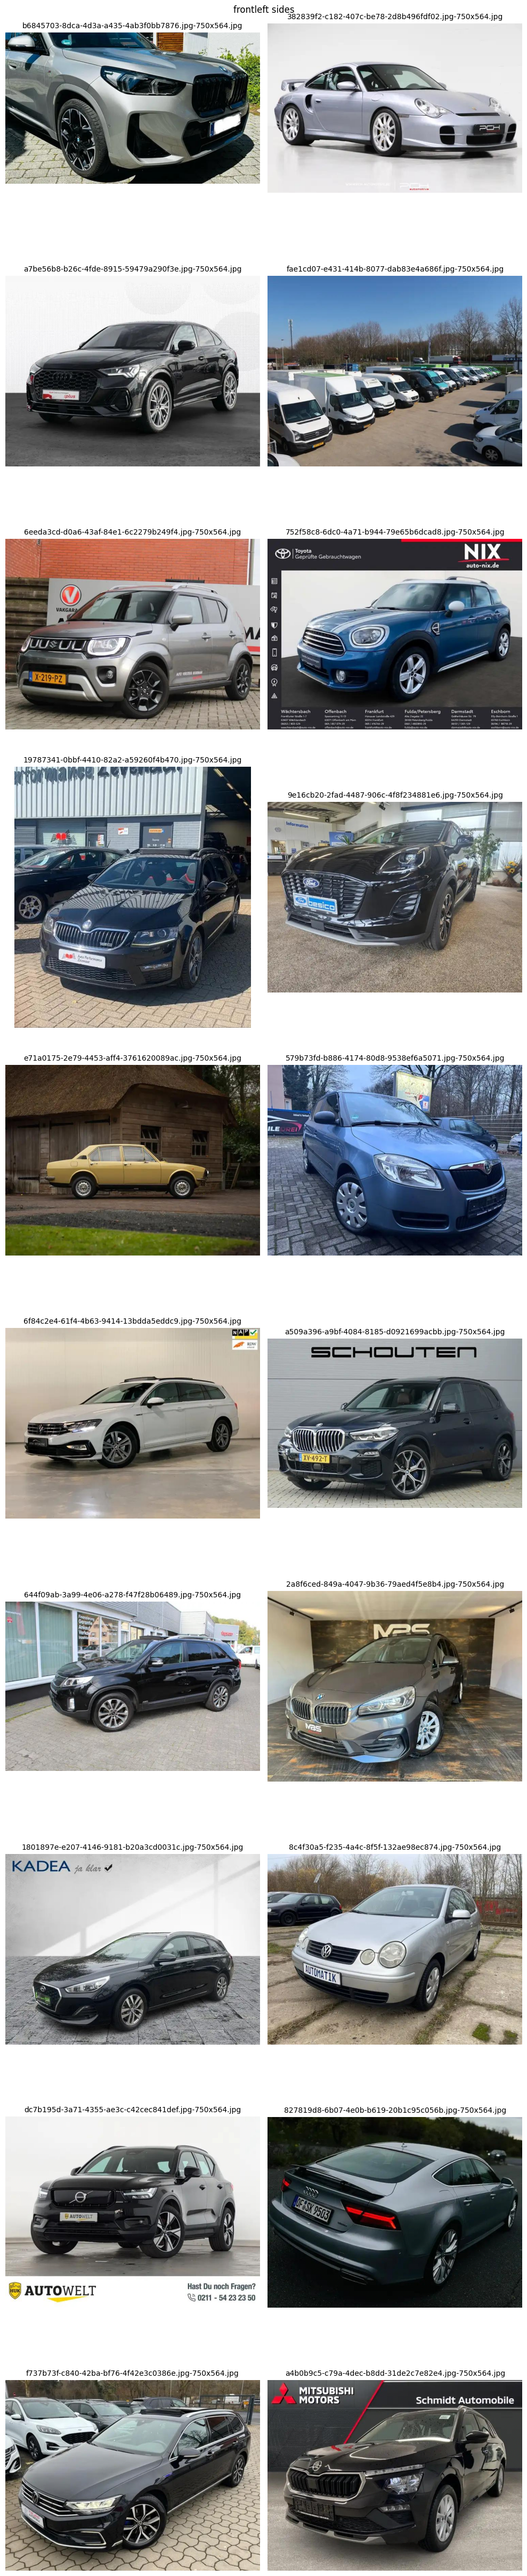

In [129]:
show_for = 'frontleft'
show = random_unlabled_data.query(f"predicted_label == '{show_for}' ")['abs_image_path'].to_list()

render_images(show, f'{show_for} sides')

# Bonus: are bounding boxes worth the effort?

In [164]:
testsize = 5000
new_sample = unlabeled_data.sample(testsize)

performance_nobox = extract_features(new_sample, False, True)
performance_wbox = extract_features(new_sample, True, True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━

Text(0.5, 1.0, 'Computation Times')

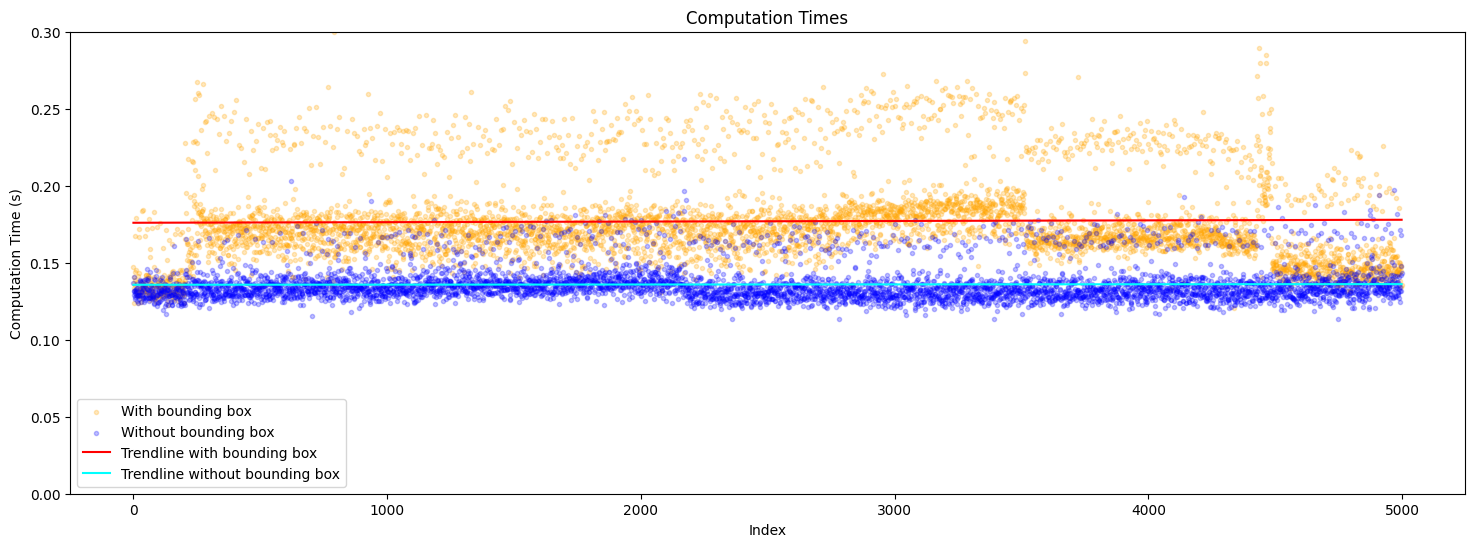

In [165]:
items = len(performance_nobox[1:])
plt.figure(figsize=(18, 6))

# Plot the first list in orange
plt.scatter(range(items), performance_wbox[1:], color='orange', label='With bounding box', marker='.', alpha = 0.25)

# Plot the second list in blue
plt.scatter(range(items), performance_nobox[1:], color='blue', label='Without bounding box', marker='.', alpha = 0.25)

# Add trendline for the first list (orange)
z_wbox = np.polyfit(range(items), performance_wbox[1:], 1)  # Linear fit (1st degree polynomial)
p_wbox = np.poly1d(z_wbox)
plt.plot(range(items), p_wbox(range(items)), color='red',  label='Trendline with bounding box')

# Add trendline for the second list (blue)
z_nobox = np.polyfit(range(items), performance_nobox[1:], 1)  # Linear fit (1st degree polynomial)
p_nobox = np.poly1d(z_nobox)
plt.plot(range(items), p_nobox(range(items)), color='cyan', label='Trendline without bounding box')

plt.ylim(0.0, 0.3)
plt.legend()

# Labels and title
plt.xlabel('Index')
plt.ylabel('Computation Time (s)')
plt.title('Computation Times')